In [1]:
# Needed to import modules from helpers
import sys
import os
import time
import requests
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.cm as cm

import esm
from io import StringIO
from Bio import SeqIO

current_dir = os.getcwd()
# Gehe einen Ordner nach oben
project_root = os.path.abspath(os.path.join(current_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from helpers import helper

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Load ESM model to GPU

In [2]:
# kleineres Modell 'esm2_t6_8M_UR50D' zum testen 
# verwendet 36-layer Transformer trained on UniParc" (ca. 670 Mio. Parameter ) im Paper.
model, alphabet = esm.pretrained.esm1_t6_43M_UR50S()

if torch.cuda.is_available():
    model = model.cuda()
    print("Modell auf GPU geladen.")

# Get Data

In [3]:
# These are Eukaryotic Orthologous Groups (KOGs) for key proteins.
orthologous_groups = [
    "KOG0069",  #Enolase (Housekeeping, meist Single-Copy -> saubere Punkte)
    "KOG0100", # HSP90 (Referenz aus dem Paper Fig. 7, strukturell interessant)
    "KOG3889", #, Hämoglobin Beta (Zeigt gut die Evolution Vögel vs. Säuger)
    "KOG2064" # Calmodulin (Referenz aus Paper Fig. 7, sehr konserviert)
]

data = []

for group in orthologous_groups:
    url = f"http://eggnogapi5.embl.de/nog_data/json/fasta/{group}"

    # print(url)

    # When adding a try except block we ensure that the program continues even if a request fails
    try:
        response = requests.get(url)

        fasta_content = response.json().get('fasta', '')

        for item in fasta_content.split('>')[1:]:

            # print(f"specimen: {item.split('.')[0]}")
            # print(f"gene: {item.splitlines()[0].split('.')[1]}")
            # print(f"sequence: {item.splitlines()[1]}")

            data.append({
                "group_id": group,
                "specimen": item.split('.')[0],
                "gene": item.splitlines()[0].split('.')[1],
                "sequence": item.splitlines()[1]
            })
        
    except Exception as e:
        print(f"Error {group}: {e}")



In [4]:
data_df= pd.DataFrame(data)
print(data_df.info())
data_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4400 entries, 0 to 4399
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   group_id  4400 non-null   object
 1   specimen  4400 non-null   object
 2   gene      4400 non-null   object
 3   sequence  4400 non-null   object
dtypes: object(4)
memory usage: 137.6+ KB
None


,group_id,specimen,gene,sequence
0,KOG0069,2711,XP_006465618,MESIGVLMACPMNTYLEQELERRFNLFKFWTVSDKTQFLKAQQNNI...
1,KOG0069,2711,XP_006465733,MDNNSNNIIVLMVCPVSNYLEQEIEKSFKVFKLWHFEDKEQFINTH...
2,KOG0069,2711,XP_006470346,MAMKRVASSAINAFASSGFLRSSSRFSRHYASSGSKKIVGVFYKGN...
3,KOG0069,2711,XP_006477345,MPTEEERPVVLIHRIPALKQPLASLSERFTLLDPLLHSADSTHSFL...
4,KOG0069,2711,XP_006478173,MAFKPKSIWRLAKIVNFHLGLPNLVPNGCGFASDLRFFTKWECCSA...


In [5]:
# Chicken (Gallus gallus)
# TaxID: 9031
mask_chicken = data_df['specimen'] == "9031"
data_df[mask_chicken]

# Human (Homo sapiens)
# TaxID: 9606 
mask_human = data_df['specimen'] == "9606"
data_df[mask_human]

# Chimpanzee (Pan troglodytes)
# TaxID: 9598
mask_chimpanzee = data_df['specimen'] == "9598"
data_df[mask_chimpanzee]

# Mouse (Mus musculus)
# TaxID: 10090
mask_mouse = data_df['specimen'] == "10090"
data_df[mask_mouse]

,group_id,specimen,gene,sequence
1032,KOG0069,10090,ENSMUSP00000047218,MKPARLMKVFVTGPLPAEGRAALAQAADCEVEQWNSDDPIPRKDLE...
2929,KOG0100,10090,ENSMUSP00000059923,MGQNRPASSLRDPGVRGCRGGRHPRYFFFFFLELMEPEETLESESS...
2930,KOG0100,10090,ENSMUSP00000097747,MMKFTVVAAALLLLGAVRAEEEDKKEDVGTVVGIDLGTTYSCVGVF...
3676,KOG3889,10090,ENSMUSP00000111624,MWYHKLLHQQSRLRNLMKRGNIAQGLHLSNFKSLFSSSIHWCHTTS...
4163,KOG2064,10090,ENSMUSP00000022470,MSAGPGWEPCTKRPRWGAAGTSAPTASDSRSFPGRQRRVLDPKDAP...


In [6]:
# Needed to make run as test
data_df = data_df.sample(200)

In [7]:
# Get the labels for genes and species and the according sequences
labels = list(data_df["group_id"])
seqs = list(data_df["sequence"])

### Hypothesis 1:

The model learns to group proteins based on their evolutionary origin/relationship (homology). Proteins belonging to the same sequence family (orthologs = genes with same ancestor, which have diverged in their sequence a bit) are expected to lie close to one another in the embedding space, even if their sequences have diverged due to mutations.

While the organization of proteins in the representation space is diffuse prior to training, we expect clear clusters to emerge after training, reflecting evolutionary relationships.

### Method:

Each protein (sequence x) is processed by the Transformer model. We extract the final hidden representation for sequence token. To obtain a single vector representation for the entire protein, we average these values across the sequence length (mean pooling).​	
 
This process projects each Sequence/Protein as a single point in a high-dimensional space. To visualize this high-dimensional structure, we use t-SNE (t-Distributed Stochastic Neighbor Embedding) to project the embeddings onto two dimensions for analysis

### Unigram Embeddings

In [ ]:
# This baseline maps each sequence to a vector of normalized amino acid counts 
def get_unigram_embeddings(sequences):
    alphabet = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_idx = {aa: i for i, aa in enumerate(alphabet)}
    
    # Create matrix: (Num_Sequences x 20)
    embeddings = np.zeros((len(sequences), 20))
    
    for i, seq in enumerate(sequences):
        if len(seq) == 0: continue
        
        # Count residues
        for char in seq.upper():
            if char in aa_to_idx:
                idx = aa_to_idx[char]
                embeddings[i, idx] += 1
                
        # Normalize by length to get frequencies
        embeddings[i] = embeddings[i] / len(seq)
        
    return embeddings

# Calculate Unigram Embeddings
emb_unigram = get_unigram_embeddings(seqs)

: 

### Untrained Transformer Embeddings

In [ ]:
# 2. Get embeddings before pretraining (natürlich ist hier ein Problem, dass wir den seed nicht kennen alleine deshalb werden sich hier Sachen vom original Paper unterscheiden)
print("Calculating UNTRAINED Embeddings...")
untrained_model = helper.randomize_model(model)

if torch.cuda.is_available(): 
    untrained_model = untrained_model.cuda()

# Schritt 1: Calculate final hidden representations
token_reps_untrained, batch_strs_untrained = helper.get_hidden_representations(untrained_model, alphabet, labels, seqs)

# Schritt 2: Calculate Untrained Embeddings
emb_untrained = helper.get_protein_embedding(token_reps_untrained, batch_strs_untrained)

Calculating UNTRAINED Embeddings...
Processing 200 sequences in batches of 1...


### Trained Transformer Embeddings

In [ ]:
# 1. Get embeddings after pretraining
print("Calculating TRAINED Embeddings...")

# Schritt 1: Calculate final hidden representations
token_reps_trained, batch_strs_trained = helper.get_hidden_representations(model, alphabet, labels, seqs)

# Schritt 2: Calculate Trained Embeddings
emb_trained = helper.get_protein_embedding(token_reps_trained, batch_strs_trained)

Calculating TRAINED Embeddings...
Processing 100 sequences in batches of 1...


### TSNE Dimensionality reduction

In [ ]:
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d_untrained = tsne.fit_transform(emb_untrained)

tsne_trained = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d_trained = tsne_trained.fit_transform(emb_trained)

tsne = TSNE(n_components=2, perplexity=5, random_state=42)
emb_2d_unigram = tsne.fit_transform(emb_unigram)

### TSNE Visualization

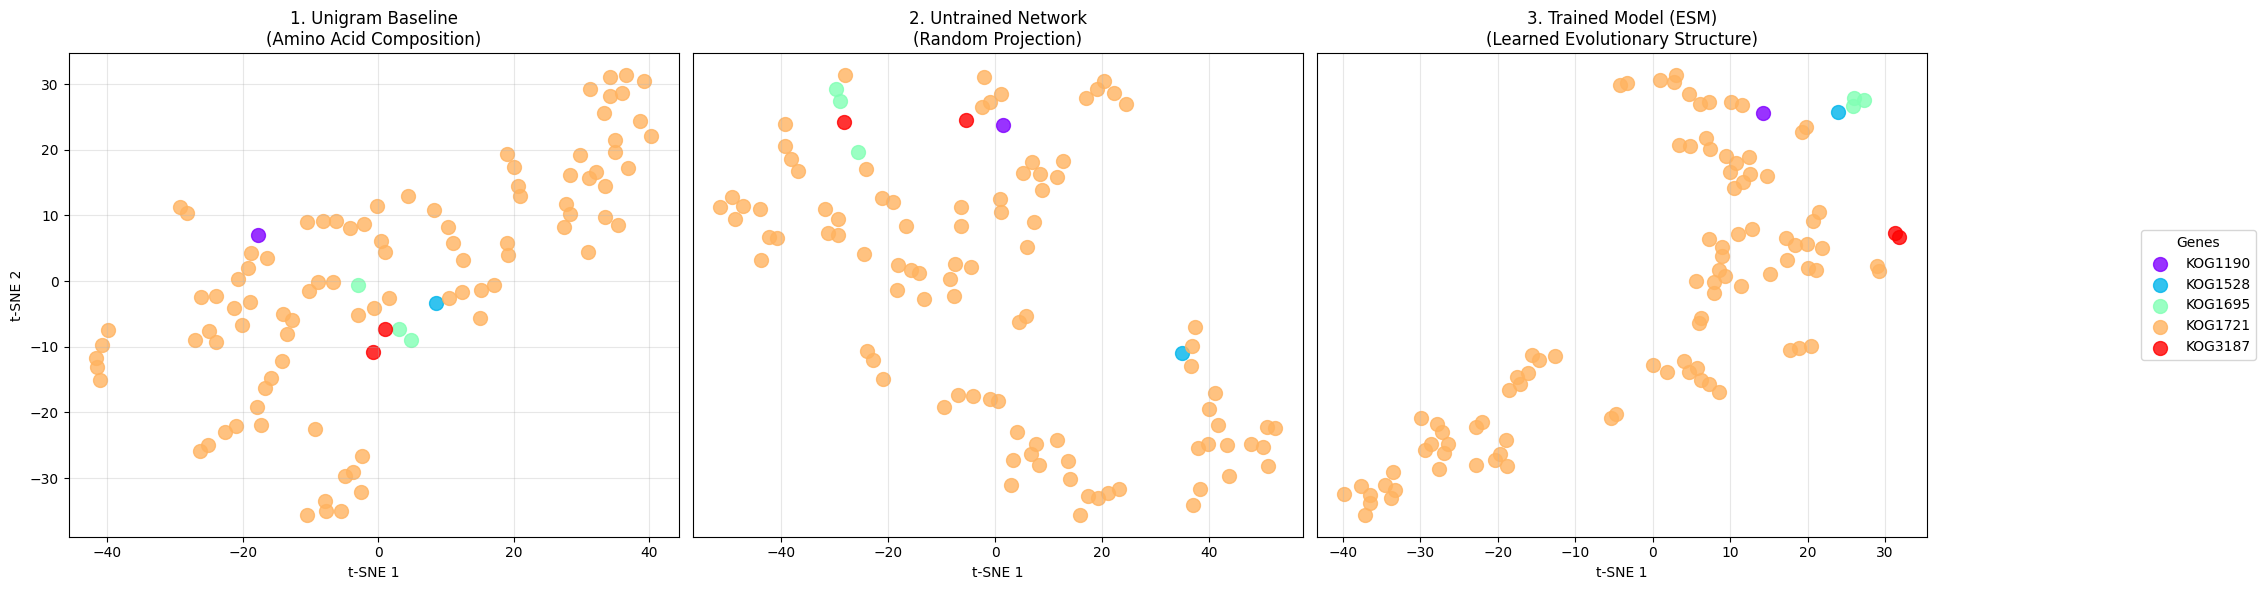

In [ ]:
# 1. Setup Colors
# Extract unique gene names for coloring
unique_genes = sorted(list(set(labels)))
colors = cm.rainbow(np.linspace(0, 1, len(unique_genes)))
gene_color_map = dict(zip(unique_genes, colors))

# 2. Setup Figure (Now 1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(21, 6))

# 3. Plotting Loop (Iterate by Gene to keep colors/legend clean)
for gene in unique_genes:
    # Find all indices for this specific gene
    # (Assuming labels list is available as defined in previous steps)
    indices = [i for i, label in enumerate(labels) if label.startswith(gene)]
    
    color = gene_color_map[gene]
    
    if indices:
        # --- Panel 1: Unigram Baseline (Input from your snippet) ---
        ax1.scatter(emb_2d_unigram[indices, 0], emb_2d_unigram[indices, 1], 
                    color=color, s=100, alpha=0.8, label=gene)
        
        # --- Panel 2: Untrained Model ---
        ax2.scatter(emb_2d_untrained[indices, 0], emb_2d_untrained[indices, 1], 
                    color=color, s=100, alpha=0.8) # No label here to avoid duplicate legend
        
        # --- Panel 3: Trained Model ---
        ax3.scatter(emb_2d_trained[indices, 0], emb_2d_trained[indices, 1], 
                    color=color, s=100, alpha=0.8)

# 4. Styling and Titles

# Ax1: Unigram
ax1.set_title("1. Unigram Baseline\n(Amino Acid Composition)")
ax1.set_xlabel("t-SNE 1")
ax1.set_ylabel("t-SNE 2")
ax1.grid(True, alpha=0.3)

# Ax2: Untrained
ax2.set_title("2. Untrained Network\n(Random Projection)")
ax2.set_xlabel("t-SNE 1")
ax2.set_yticks([]) # Optional: Hide ticks for cleaner look
ax2.grid(True, alpha=0.3)

# Ax3: Trained
ax3.set_title("3. Trained Model (ESM)\n(Learned Evolutionary Structure)")
ax3.set_xlabel("t-SNE 1")
ax3.set_yticks([]) 
ax3.grid(True, alpha=0.3)

# 5. Legend
# We only need one legend since the colors are consistent
# Placing it outside the last plot
handles, plot_labels = ax1.get_legend_handles_labels()
fig.legend(handles, plot_labels, loc='center right', title="Genes", bbox_to_anchor=(1.08, 0.5))

plt.tight_layout()
# Adjust right margin to make room for the external legend
plt.subplots_adjust(right=0.92) 
plt.show()

### Hypothesis 2: 

unsupervised learning encodes biological variations into the structure of the representation space. Das Modell lernt also ohne explizite Labels, fundamentale biologische Unterscheidungen zwischen species und gen familie. Die Autoren wenden eine Hauptkomponentenanalyse (PCA) auf die gelernten Repräsentationen von vier orthologen Genen über vier verschiedene Spezies hinweg an:

### Gene:
- "KOG1695" Glutamyl-tRNA synthetase
- "KOG1528" Phenylalanyl-tRNA synthetase
- "KOG1721" Alanyl-tRNA synthetase
- "KOG3187" Arginyl-tRNA synthetase


### Spezies:
- Chicken (Gallus gallus), TaxID: 9031
- Human (Homo sapiens), TaxID: 9606 
- Chimpanzee (Pan troglodytes), TaxID: 9598
- Mouse (Mus musculus), TaxID: 10090

### Beobachtung: 
Die PCA enthüllt, dass das trainierte Modell automatisch Achsen bildet, die biologisch interpretierbar sind:
- Eine Spezies-Achse (horizontal), die Organismen unterscheidet.
- Eine Orthologie-Achse (vertikal), die Gene unterscheidet.

Vergleich: Diese Struktur fehlt in untrainierten Modellen oder simplen Unigram-Modellen komplett. 

### Filter Data

In [ ]:
target_ortholog_group = ["KOG0069", "KOG0100", "KOG3889", "KOG2064"]
target_species = ["9031", "9606", "9598", "10090"]

group_mask = data_df['group_id'].isin(target_ortholog_group)
species_mask = data_df['specimen'].isin(target_species)

filtered_4by4_data = data_df[group_mask & species_mask]

### Compute PCA

In [ ]:

# Compute Embeddings for the filtered subset
token_reps, batch_strs = helper.get_hidden_representations(
    model, alphabet, 
    filtered_4by4_data['group_id'].tolist(), 
    filtered_4by4_data['sequence'].tolist()
)
embeddings_4by4_subset = helper.get_protein_embedding(token_reps, batch_strs)

#Run PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(embeddings_4by4_subset)

Processing 2322 sequences in batches of 1...


KeyboardInterrupt: 

### Visualize PCA

In [ ]:

plt.figure(figsize=(12, 9))

unique_groups = list(filtered_4by4_data['group_id'].unique())
colors = plt.cm.tab10(np.linspace(0, 1, max(1, len(unique_groups))))

# Map each group_id to a specific color
group_to_color = {gid: colors[i % len(colors)] for i, gid in enumerate(unique_groups)}

# Map TaxIDs to readable names for the plot text
taxid_map = {
    9031: 'Chicken', '9031': 'Chicken',
    9606: 'Human',   '9606': 'Human',
    9598: 'Chimp',   '9598': 'Chimp',
    10090: 'Mouse',  '10090': 'Mouse'
}

# --- 4. Plotting Loop ---
for i in range(len(filtered_4by4_data)):
    # Get row data
    row = filtered_4by4_data.iloc[i]
    gid = row['group_id']
    specimen = row['specimen']
    
    # Get plot properties
    col = group_to_color[gid]
    # Use the map to get a name, otherwise fallback to the ID string
    label_text = taxid_map.get(specimen, str(specimen))
    
    # Scatter plot
    plt.scatter(X_pca[i, 0], X_pca[i, 1],
                color=col, s=150, alpha=0.8, edgecolor='k', linewidth=0.5)

    # Annotate with species name (slightly offset)
    plt.text(X_pca[i, 0] + 0.02, X_pca[i, 1] + 0.02, label_text,
             fontsize=10, fontweight='bold', alpha=0.8)

# --- 5. Legend and Layout ---
handles = [plt.Line2D([0], [0], marker='o', color='w', label=gid,
                      markerfacecolor=group_to_color[gid], markersize=12, markeredgecolor='k')
           for gid in unique_groups]

plt.legend(handles=handles, title="Orthologous Group", bbox_to_anchor=(1.02, 1), loc='upper left')

plt.title("PCA on Filtered Sequences (Specimen vs Group)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.grid(True, linestyle='--', alpha=0.25)

plt.tight_layout(rect=[0, 0, 0.85, 1.0]) # Make room for legend
plt.show()

# !! SHOULD ORGANIZE IN A GRID 

Hypothesis 3: biological properties are encoded along independent directions in the representation space

Then if we have two related sequences which only distiguish themselves by one unique property, they should only be differing along one of these separate axes

Analogy: 

o	Vector arithmetics in NLP: King – Royalty = Women 

Vector arithmetics in Biology: Hemoglobin - Rat = .. 

-	In SI Appendix, Fig. S1, we find that learning improves recovery of target proteins under queries encoded as linear transformations along the species or gene axes
o	•  "Queries encoded as linear transformations...": Das ist die "Rechen-Anfrage". Die Forscher haben genau das getan, was wir besprochen haben:
o	Beispiel (species axis): Sie haben den Vektor-Unterschied zwischen zwei Spezies berechnet, z.B. .
o	Dann haben sie eine "query" (Anfrage) gestellt: 
o	•  "Target proteins": Das ist die korrekte Antwort auf die Rechen-Anfrage. In unserem Beispiel wäre das "target protein" das Maus-Hämoglobin.
o	•  "Recovery of target proteins": Das bedeutet "das korrekte Ziel-Protein finden".
o	Das Modell macht die Rechnung () und erhält einen Ergebnis-Vektor.
o	Dann schaut es im gesamten Datensatz nach: Welches "echte" Protein-Embedding liegt diesem Ergebnis-Vektor am nächsten?
o	Wenn es "Maus-Hämoglobin" findet, war die "recovery" erfolgreich.
o	•  "Learning improves recovery...": Das ist das Ergebnis.
o	Bei einem untrainierten Modell (vor dem "learning") ist das Ergebnis dieser Rechnung Müll. Es findet das "target protein" nicht.
o	Bei einem trainierten Modell (nach dem "learning") funktioniert die Rechnung. Das Modell "recovers" (findet) das korrekte "target protein" (Maus-Hämoglobin) mit hoher Genauigkeit.

Vector(Human Insulin)−Vector(Human)+Vector(Mouse)≈Vector(Mouse Insulin)